# Create maps showing average demographic characteristic (e.g. IMD score) for each IVT unit catchment

Using shapefile from from `02_combine_demographic_data.ipynb`, create maps of with the weighted population average for each IVT unit of:
* IMD score
* Income domain score

Notes:
* When using the 2018 age CSV file, there were two Welsh hospital catchments (CF311RQ Bridgend, CF144XW Cardiff) that each contained two LSOAs that are not present in that age file (Rhondda Cynon Taf 023F, Rhondda Cynon Taf 027F, Rhondda Cynon Taf 027G, Rhondda Cynon Taf 023G). Since we use the population count from this age csv file to calculate a weighted sum for the IVT catchment, these LSOAs were previously (1) excluded from the weighted mean, and (2) excluded from the map. However, in the 2020 age CSV file now used, these areas have data, so **these steps are no longer required and have been removed**.
* To help with geopandas use https://github.com/MichaelAllen1966/2010_geopandas/blob/main/geopandas_1.ipynb
* Uses MatPlotLib for mapping the data since that gives us more power than the GeoPandas DataFrame plot method.

## 1 Set up

### 1.1 Import libraries and define file paths

In [1]:
import contextily as ctx
from dataclasses import dataclass
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import os
import pandas as pd
from pandas.api.types import is_numeric_dtype

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data'
    countries = 'Countries_(December_2022)_GB_BFC.zip'
    collated = 'collated_data_amb.csv'
    ivt_catchment = 'ivt_catchment.shp'
    hospitals = 'stroke_hospitals_2022.csv'
    amb_catchment = 'amb_catchment.shp'


paths = Paths()

### 1.2 Load data

We convert data to epsg:3857, as that is needed when using base maps. Base maps are a reference map that you can then overlay your data onto - for example, a topographic basemap showing elevation. We can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. CRS to consider:
* EPSG:27700 -- BNG (British National Grid Eastings and Northings).
* EPSG:27700 OSGB 1936 / British National Grid -- United Kingdom Ordnance Survey. Co-ordinates are in Eastings (X) and Northings (Y).
* EPSG:4326 WGS 84 -- WGS84 - World Geodetic System 1984. Co-ordinates are in Longitude (X) and Latitude (Y).
* EPSG:3857 - projection for displaying lat/long as a flat map

**IVT catchment shapefile** - shape file of the catchments for the IVT units in England and Wales, which we load into a GeoPandas DataFrame. Note that we can set the crs (Coordinate Reference System) when loading a GeoPandas DataFrame. EPSG:27700 is the crs to use when geography is in BNG (British National Grid Eastings and Northings). Note: If this fails to run, you need to run `02_create_ivt_catchment_shapefile.ipynb` to generate the IVT catchment shapefile.

,LSOA11NM,LSOA11CD,LSOA11NMW,geometry
closest_iv,,,,
B152TH,Birmingham 067A,E01008881,Birmingham 067A,"MULTIPOLYGON (((403011.723 266679.152, 402597...."
B714HJ,Birmingham 037A,E01008899,Birmingham 037A,"MULTIPOLYGON (((395950.714 272162.470, 395950...."


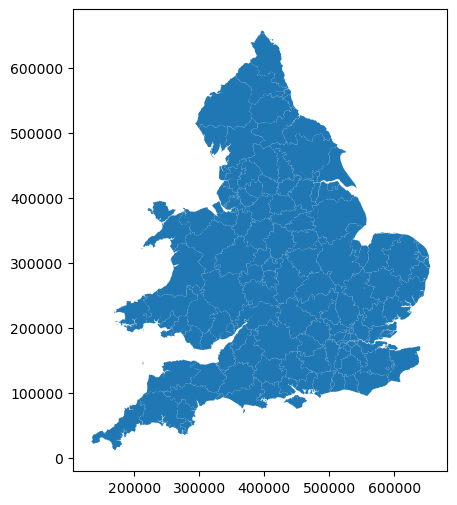

In [3]:
# Load IVT catchment shapefile
gdf_ivt_catchment = gpd.read_file(
    os.path.join(paths.data, paths.ivt_catchment), crs='EPSG:27700')

# Set index
gdf_ivt_catchment.set_index(['closest_iv'], inplace=True)

# Preview the dataframe
display(gdf_ivt_catchment.head(2))

# Plot the shapefile
gdf_ivt_catchment.plot(figsize=(6, 6))
plt.show()

# Convert crs to epsg 3857
gdf_ivt_catchment = gdf_ivt_catchment.to_crs(epsg=3857)

**Country outline** - used to produce outline of countries on the map.

,FID,CTRY22CD,CTRY22NM,CTRY22NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,E92000001,England,Lloegr,394883,370883,-2.07811,53.23497,{096C3540-B006-4D2D-BCDF-B3E945B80D51},1.358939e+07,1.304623e+11,"MULTIPOLYGON (((-712384.210 6422975.926, -7123..."
2,3,W92000004,Wales,Cymru,263405,242881,-3.99417,52.06741,{1DFA050A-C94B-4E58-8210-DE8274C7C33E},3.273688e+06,2.078260e+10,"MULTIPOLYGON (((-347425.136 6688819.680, -3474..."


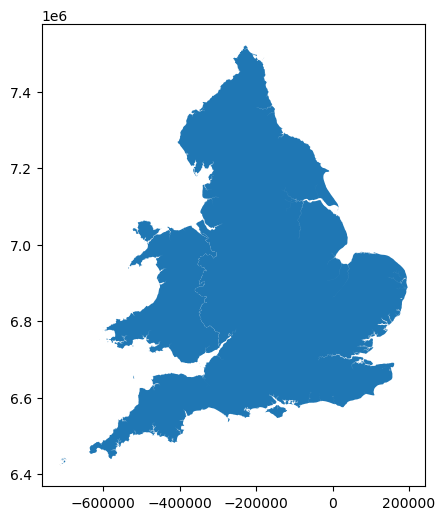

In [4]:
# Load country outline
outline = gpd.read_file(os.path.join(paths.data, paths.countries))

# Drop Scotland
mask = outline['CTRY22NM'] != 'Scotland'
outline = outline[mask]

# Convert to epsg:3857
outline = outline.to_crs(epsg=3857)

# Preview the dataframe
display(outline.head())

# Plot the shapefile
outline.plot(figsize=(6, 6))
plt.show()

**LSOA information** - load `collated_data.csv` produced by `01_combine_demographic_data.ipynb` which has information on each LSOA.

In [5]:
df_lsoa = pd.read_csv(os.path.join(paths.data, paths.collated))
df_lsoa.head(2)

,LSOA,admissions,closest_ivt_unit,closest_ivt_unit_time,closest_mt_unit,closest_mt_unit_time,closest_mt_transfer,closest_mt_transfer_time,total_mt_time,ivt_rate,...,age_band_males_65,age_band_males_70,age_band_males_75,age_band_males_80,age_band_males_85,age_band_males_90,ambulance_service,local_authority_district_22,LAD22NM,country
0,Welwyn Hatfield 010F,0.666667,SG14AB,18.7,NW12BU,36.9,CB20QQ,39.1,57.8,6.8,...,33,28,26,14,5,3,East of England,Welwyn Hatfield,Welwyn Hatfield,England
1,Welwyn Hatfield 012A,4.000000,SG14AB,19.8,NW12BU,36.9,CB20QQ,39.1,58.9,6.8,...,24,18,21,12,5,4,East of England,Welwyn Hatfield,Welwyn Hatfield,England


**Hospital data** - load data on each hospital, with aim of getting locations of hospitals that provide IVT.

In [6]:
# Read in data on each hospital
gdf_units = gpd.read_file(os.path.join(paths.data, paths.hospitals))

# Combine get geometry from Easting and Northing columns
gdf_units["geometry"] = gpd.points_from_xy(
        gdf_units.Easting, gdf_units.Northing)
gdf_units = gdf_units.set_crs(epsg=27700)

# Restrict to the units delivering thrombolysis
mask = gdf_units['Use_IVT'] == '1'
gdf_units = gdf_units[mask]

# Preview dataframe
gdf_units.head(2)

# Convert crs to epsg 3857
gdf_units = gdf_units.to_crs(epsg=3857)

**Ambulance catchment shapefile**

,LSOA11NM,LSOA11CD,LSOA11NMW,geometry
ambulance_,,,,
East Midlands,North East Lincolnshire 010A,E01013128,North East Lincolnshire 010A,"MULTIPOLYGON (((433631.972 296489.554, 433631...."
East of England,Peterborough 004A,E01015589,Peterborough 004A,"MULTIPOLYGON (((503939.688 193345.500, 503939...."


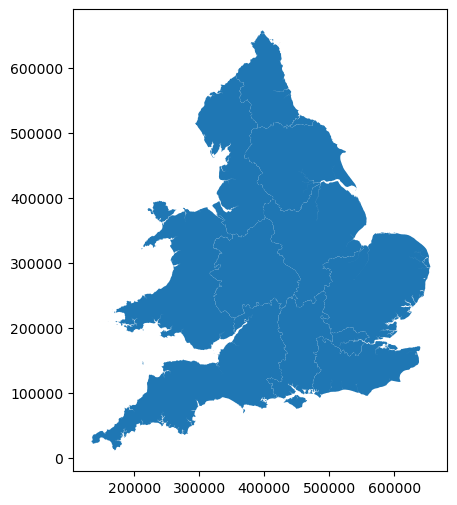

In [7]:
# Load IVT catchment shapefile
gdf_amb_catchment = gpd.read_file(
    os.path.join(paths.data, paths.amb_catchment), crs='EPSG:27700')

# Set index
gdf_amb_catchment.set_index(['ambulance_'], inplace=True)

# Preview the dataframe
display(gdf_amb_catchment.head(2))

# Plot the shapefile
gdf_amb_catchment.plot(figsize=(6, 6))
plt.show()

# Convert crs to epsg 3857
gdf_amb_catchment = gdf_amb_catchment.to_crs(epsg=3857)

### 1.3 Find weighted averages by closest IVT unit

Group data by closest IVT unit and calculate the weighted average of specified columns - [see stackoverflow tutorial here](https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe).

In [8]:
# Define a function to compute the weighted mean
def wm(x):
    return np.average(x, weights=df_lsoa.loc[x.index, 'population_all'])


# Define a function for finding population and average by IVT unit
def ivt_weighted_av(df_lsoa, col, new_col):
    '''
    Groups df_lsoa by closest IVT unit, then finds total population size and
    the weighted average of the specified column
    Inputs:
    - df_lsoa - dataframe, information about each LSOA
    - col - string, column to create weighted average of
    - new_col - string, name of new column containing weighted average
    Output:
    - df - dataframe, with population and weighted mean for each IVT unit
    '''
    df = (df_lsoa
          .groupby('closest_ivt_unit')
          .agg(all_persons=('population_all', 'sum'),
               weighted_mean=(col, wm)))
    df = df.rename(columns={'weighted_mean': new_col})
    return (df)

In [9]:
# Weighted mean income domain score by closest IVT unit
df_ivt_ids = ivt_weighted_av(
    df_lsoa, 'income_domain_score', 'income_domain_weighted_mean')
df_ivt_ids

,all_persons,income_domain_weighted_mean
closest_ivt_unit,,
B152TH,963012,0.182951
B714HJ,1012389,0.202612
BA13NG,483031,0.083469
BA214AT,274432,0.095511
BB23HH,486120,0.177377
...,...,...
WD180HB,592250,0.080071
WF14DG,590899,0.148666
WR51DD,412669,0.093969


In [10]:
# Weighted mean IMD by closest IVT unit
df_ivt_imd = ivt_weighted_av(df_lsoa, 'imd_2019_score', 'imd_weighted_mean')
df_ivt_imd

,all_persons,imd_weighted_mean
closest_ivt_unit,,
B152TH,963012,31.488294
B714HJ,1012389,33.655519
BA13NG,483031,13.335982
BA214AT,274432,16.858199
BB23HH,486120,31.789134
...,...,...
WD180HB,592250,12.153052
WF14DG,590899,26.646876
WR51DD,412669,16.451837


### 1.4 Extract boundaries

Extract the bounds of each IVT catchment.

In [11]:
eng_wales_bounds = gdf_ivt_catchment.bounds
eng_wales_bounds.head(2)

,minx,miny,maxx,maxy
closest_iv,,,,
B152TH,-228159.802962,6.840962e+06,-186486.338536,6.891587e+06
B714HJ,-230754.673759,6.862190e+06,-174024.968174,6.926919e+06


### 1.5 Define mapping functions

Non-overlapping labels of each stroke unit - [see stackoverflow explanation here](https://stackoverflow.com/questions/43916834/matplotlib-dynamically-change-text-position).

In [12]:
def add_nonoverlapping_text_labels(units, ax, col,
                                   y_step=0.05, fontsize=7):
    '''
    Creates non-overlapping text labels for stroke units to the input axis
    Inputs:
    - units - dataframe, contains data on each hospital
    - ax - axis object, to add labels to
    - col - string, label for each position
    - y_step - number, amount to adjust position on y axis by
    - fontsize - number, size of font in labels
    Output:
    - ax - axis object with addition of text labels
    '''
    # Create empty array
    text_rectangles = []

    # Sort labels descending in y axis (gives better results)
    units.loc[:, 'sort_by'] = units.geometry.y
    units = units.sort_values(by='sort_by', ascending=False, axis=0)
    del units['sort_by']

    # Add labels to the plot
    # Loop through each stroke unit - in each loop, get x, y and label
    geom_unit = zip(units.geometry.x, units.geometry.y, units[col])
    for x, y, label in geom_unit:

        # Add label to the axis (xy is location of point)
        text = ax.annotate(
            text=label,
            xy=(x, y),  # location of point
            xytext=(8, 8),  # location of text that goes with point
            textcoords='offset points',  # offset text in points from xy value
            fontsize=fontsize,
            bbox=dict(facecolor='w', alpha=0.3, edgecolor='none',
                      boxstyle="round", pad=0.1))

        # Adjust text position by by 2 x axis points and get axes bounding box
        x, y = text.get_position()
        new_x = x - 2
        text.set_position((new_x, y))
        rect = text.get_window_extent()

        # While text intersects with other text from rectangles of axis,
        # iterate over different y positions 10 times, checking if it prevents
        # overlap. If still intersect, just use original position
        for other_rect in text_rectangles:
            iterations = 0
            while Bbox.intersection(rect, other_rect) and iterations < 10:
                x, y = text.get_position()
                new_y = y - y_step
                text.set_position((x, new_y))
                rect = text.get_window_extent()
                iterations += 1
            if iterations == 10:
                # No improved location found; use original position
                text.set_position((x, y))
            text_rectangles.append(rect)

    return (ax)

In [13]:
def plot_map(gdf, col, ax, include_legend, legend_kwds,
             units, base_map, show_labels, cmap):
    '''
    Create map of catchment areas, coloured by the provided column.
    Inputs:
    - gdf - geopandas dataframe with IVT catchment areas and col
    - col - string, column to colour map by
    - ax - axis object, to plot map on
    - include_legend - boolean, whether to display legend
    - legend_kwds - dictionary, characteristics of legend
    - units - dataframe, information on each stroke unit inc. location
    - base_map - boolean, whether to add base map
    - show_labels - boolean, whether to add hospital labels
    - cmap - string, colourmap to use
    '''
    # Plot IVT catchment areas
    gdf.plot(
        ax=ax,
        column=col,  # Column to apply colour
        antialiased=False,  # Avoids artifact boundry lines
        edgecolor='face',  # Make LSOA boundry same colour as area
        linewidth=0.0,  # Use linewidth=0 to hide boarder lines
        # vmin=0,  # Manual scale min (remove to make automatic)
        # vmax=70,  # Manual scale max (remove to make automatic)
        cmap=cmap,  # Colour map to use
        legend=include_legend,  # Whether to display legend
        legend_kwds=legend_kwds,  # Characteristics of legend
        alpha=0.7)  # Set transparency (to reveal basemap)

    # Add country border
    outline.plot(ax=ax, edgecolor='k', facecolor='None', linewidth=1.0)

    # Add location of hospitals and - if True - labels for each hospital
    units.plot(ax=ax, edgecolor='k', facecolor='w', markersize=120, marker='*')
    if show_labels:
        ax = add_nonoverlapping_text_labels(
            units, ax, 'hospital_city', y_step=0.05, fontsize=8)

    # If True, add base map, specifying same CRS and using manual zoom to
    # adjust level of detail
    if base_map:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

    # Remove x and y ticks
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

    # Turn off axis line and numbers
    ax.set_axis_off()

In [14]:
def create_map(gdf, col, col_readable, gdf_units,
               base_map, show_labels, cmap='inferno_r'):
    '''
    Creates map of England and Wales, with an inset map of London. Shows
    IVT catchment areas, coloured by value from specified column. Uses the
    plot_map() function to create each map (main and inset).
    Inputs:
    - gdf - geopandas dataframe with polygons and col
    - col - string, column to colour map by
    - col_readable - string, used for legend and plot title
    - gdf_units - dataframe, information on each stroke unit inc. location
    - base_map - boolean, whether to add base map
    - cmap - string, colourmap to use on maps, default 'inferno_r'
    '''
    # Set up figure with max dimensions of 10x10 inch
    fig, ax = plt.subplots(figsize=(20, 20))

    # Set legend kwds if is numeric, else blank
    if is_numeric_dtype(gdf[col]):
        legend_kwds = {'shrink': 0.5, 'label': f'{col_readable}'}
    else:
        legend_kwds = {}

    # Plot map for England and Wales
    plot_map(gdf, col, ax,
             include_legend=True,
             legend_kwds=legend_kwds,
             units=gdf_units,
             base_map=base_map,
             show_labels=show_labels,
             cmap=cmap)

    # Make space at bottom for inset map of London
    ax.set_ylim(ax.get_ylim()[0] - 100000, ax.get_ylim()[1])

    # Make space on right for hospital name label
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 50000)

    # Create inset axis in bottom right corner
    axins = ax.inset_axes([0.8, 0.05, 0.18, 0.18])

    # Identify London hospitals to go in the inset map
    london_mask = gdf_units["Strategic Clinical Network"] == "London SCN"
    london_hospitals = gdf_units["Hospital_name"][london_mask].to_list()
    london_units = gdf_units[london_mask]

    # Identify map area to plot in the inset map
    # initialise exteme values
    minx_ = np.inf
    miny_ = np.inf
    maxx_ = 0
    maxy_ = 0
    # Find min and max x and y for the london hospitals
    for h in london_hospitals:
        minx, miny, maxx, maxy = eng_wales_bounds.loc[h]
        minx_ = min(minx_, minx)
        miny_ = min(miny_, miny)
        maxx_ = max(maxx_, maxx)
        maxy_ = max(maxy_, maxy)

    # Set extent of inset map
    axins.set_xlim(minx_, maxx_)
    axins.set_ylim(miny_, maxy_)

    # Define lines connecting inset map to main map
    mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

    # Plot inset map of London
    plot_map(gdf, col, axins,
             include_legend=False,
             legend_kwds={},
             units=london_units,
             base_map=base_map,
             show_labels=show_labels,
             cmap=cmap)

    # Set title
    ax.set_title(f'{col_readable}')

    # Adjust for printing
    ax.margins(0)
    ax.apply_aspect()
    plt.subplots_adjust(left=0.01, right=1.0, bottom=0.0, top=1.0)
    plt.savefig(f'outputs/map_{col}.png', dpi=300)
    plt.show()

    # If colouring column is numeric, do some further analysis
    if is_numeric_dtype(gdf[col]):
        # Print information on the range and median
        display(f'The range of {col_readable} across the ' +
                f'{gdf.shape[0]} catchments is: ' +
                f'{round(gdf[col].min(),3)} to ' +
                f'{round(gdf[col].max(),3)}')
        display(f'Median: {round(gdf[col].median(),3)}')

        # Histogram showing range in that col
        plt.hist(gdf[col])
        plt.xlabel(col_readable)
        plt.ylabel('Number of catchment areas')
        plt.show()

## 2 Results

### 2.1 Size of IVT catchments

The range of people across the 113 catchments is: 87086 to 1479138
Median number of people: 483031.0


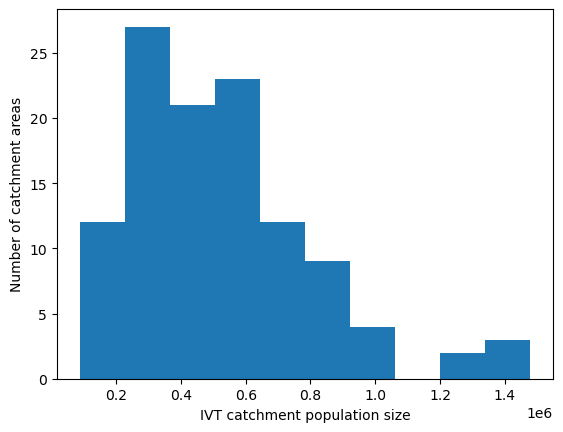

In [15]:
# Print the range in population size of each catchment area
print(f'The range of people across the {df_ivt_ids.shape[0]} catchments is: ' +
      f'{round(df_ivt_ids.all_persons.min(),1)} to ' +
      f'{round(df_ivt_ids.all_persons.max(),1)}')

# Print the median population size
print(f'Median number of people: {round(df_ivt_ids.all_persons.median(),2)}')

# Create histogram to show distribution in population size of catchment areas
plt.hist(df_ivt_ids['all_persons'])
plt.xlabel('IVT catchment population size')
plt.ylabel('Number of catchment areas')
plt.show()

### 2.2 Income domain map

Map of the weighted average income domain score by IVT catchment.

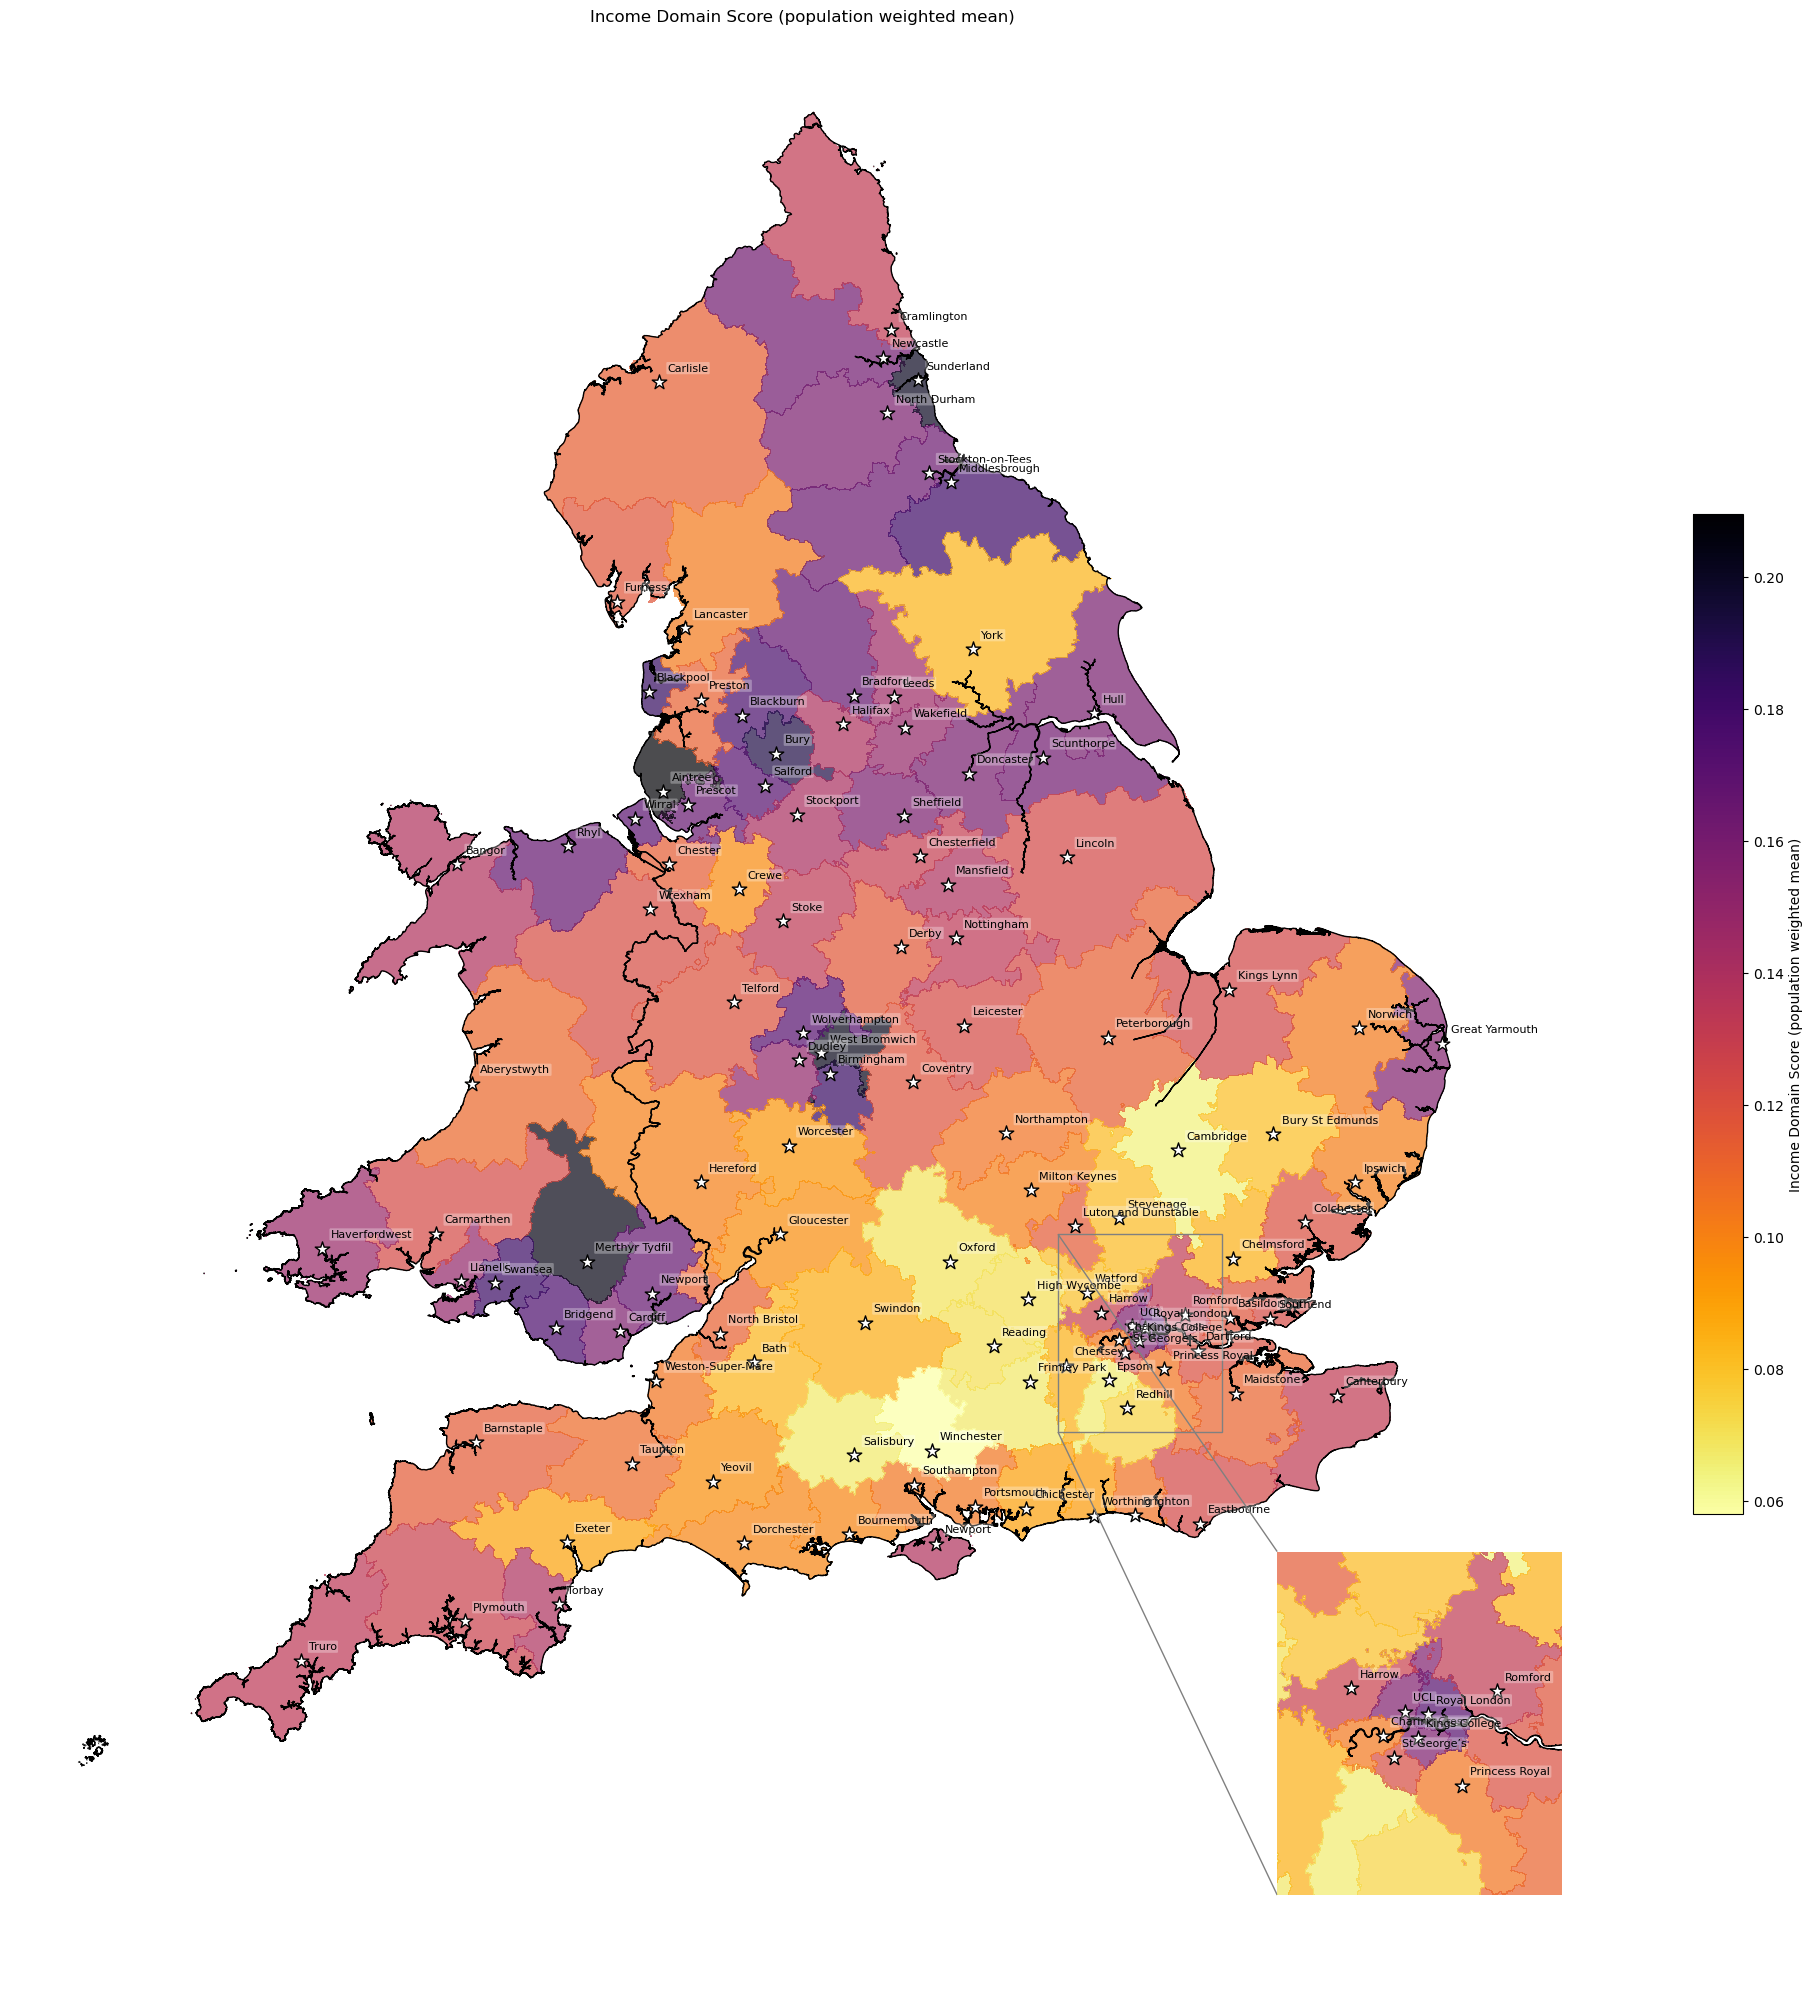

'The range of Income Domain Score (population weighted mean) across the 113 catchments is: 0.058 to 0.209'

'Median: 0.122'

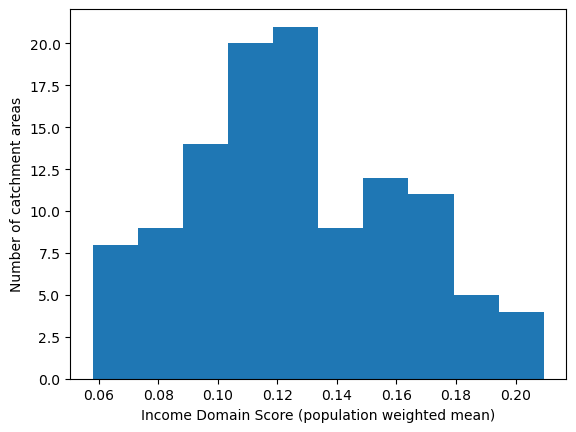

In [16]:
# Add mean IoD to geopandas dataframe
gdf_ivt_catchment = (gdf_ivt_catchment.join(
    df_ivt_ids['income_domain_weighted_mean']))

# Create map
create_map(gdf=gdf_ivt_catchment.reset_index(),
           col='income_domain_weighted_mean',
           col_readable='Income Domain Score (population weighted mean)',
           gdf_units=gdf_units,
           base_map=False,
           show_labels=True)

### 2.3 IMD map

Map of the weighted average IMD score by IVT catchment.

In [17]:
# Add mean IMD to geopandas dataframe
gdf_ivt_catchment = (gdf_ivt_catchment.join(
    df_ivt_imd['imd_weighted_mean']))

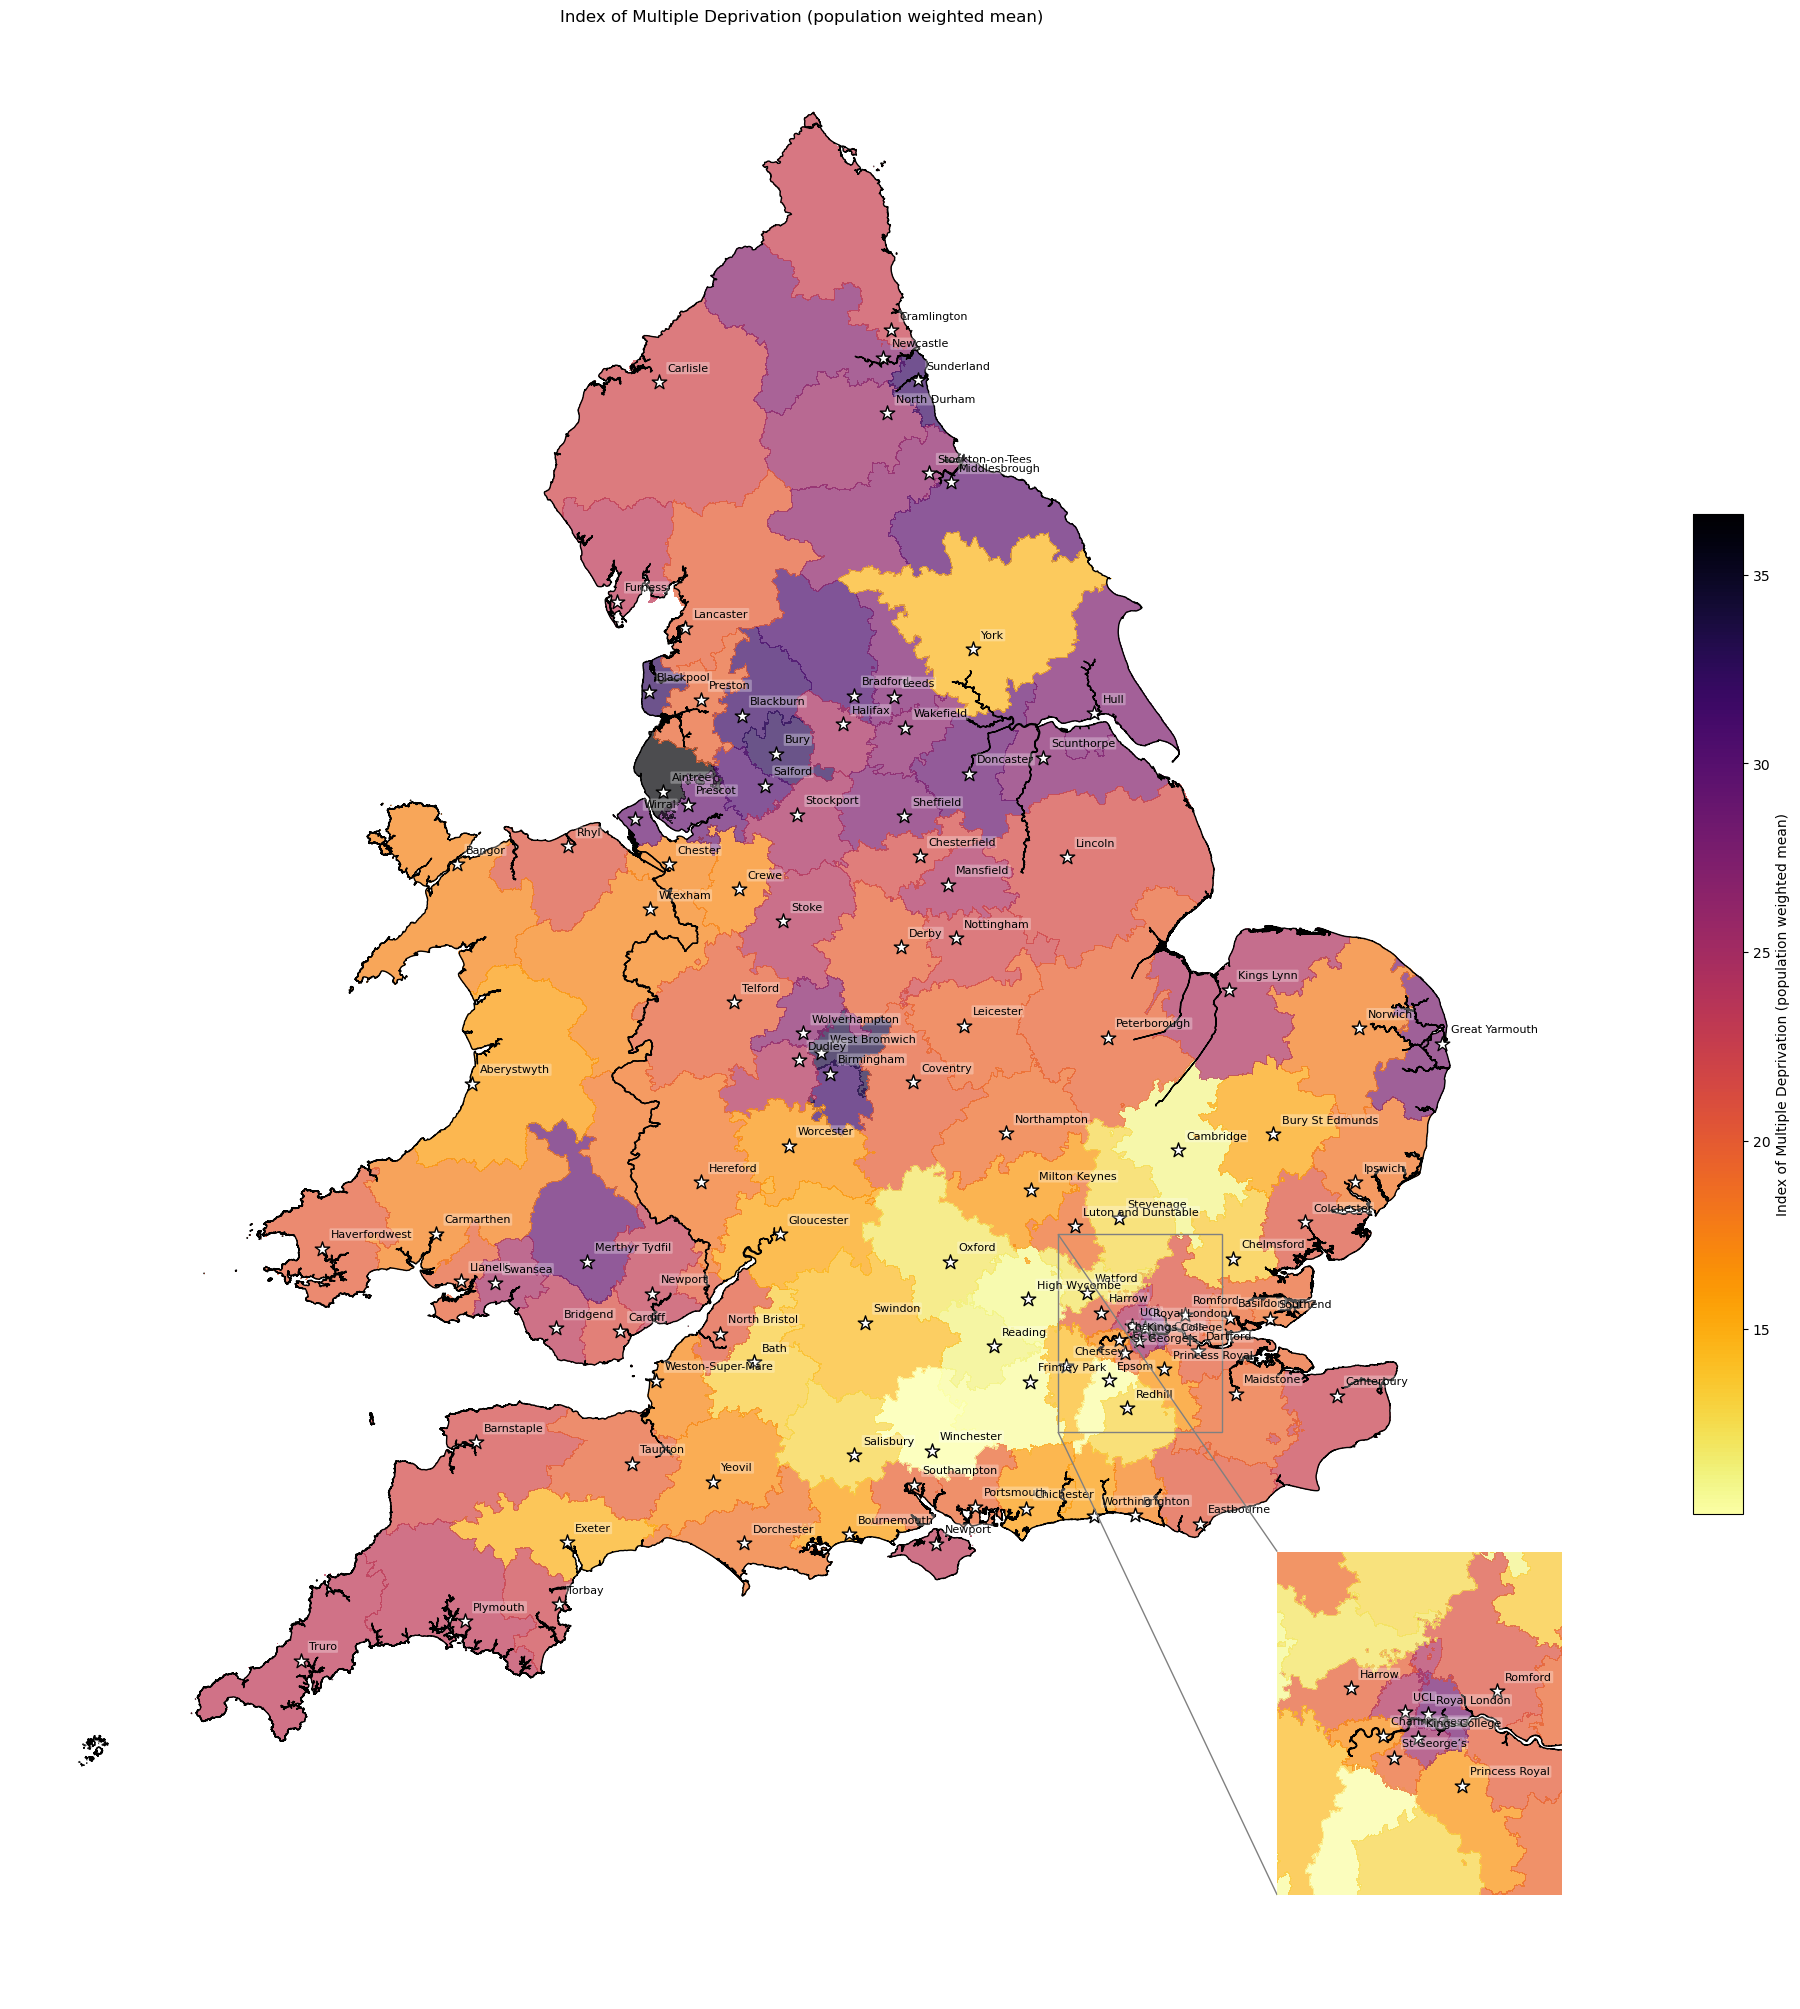

'The range of Index of Multiple Deprivation (population weighted mean) across the 113 catchments is: 10.093 to 36.601'

'Median: 20.032'

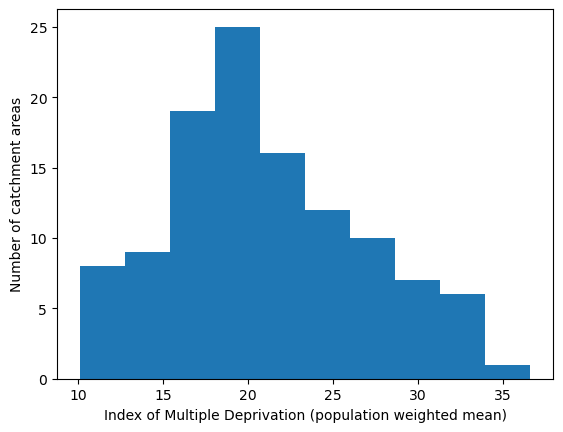

In [18]:
# Create map
create_map(
    gdf=gdf_ivt_catchment.reset_index(),
    col='imd_weighted_mean',
    col_readable='Index of Multiple Deprivation (population weighted mean)',
    gdf_units=gdf_units,
    base_map=False,
    show_labels=True)

### 2.4 Ambulance service map

In [19]:
# Add ambulance service as a column for the mapping function
gdf_amb_catchment['ambulance_service'] = gdf_amb_catchment.index

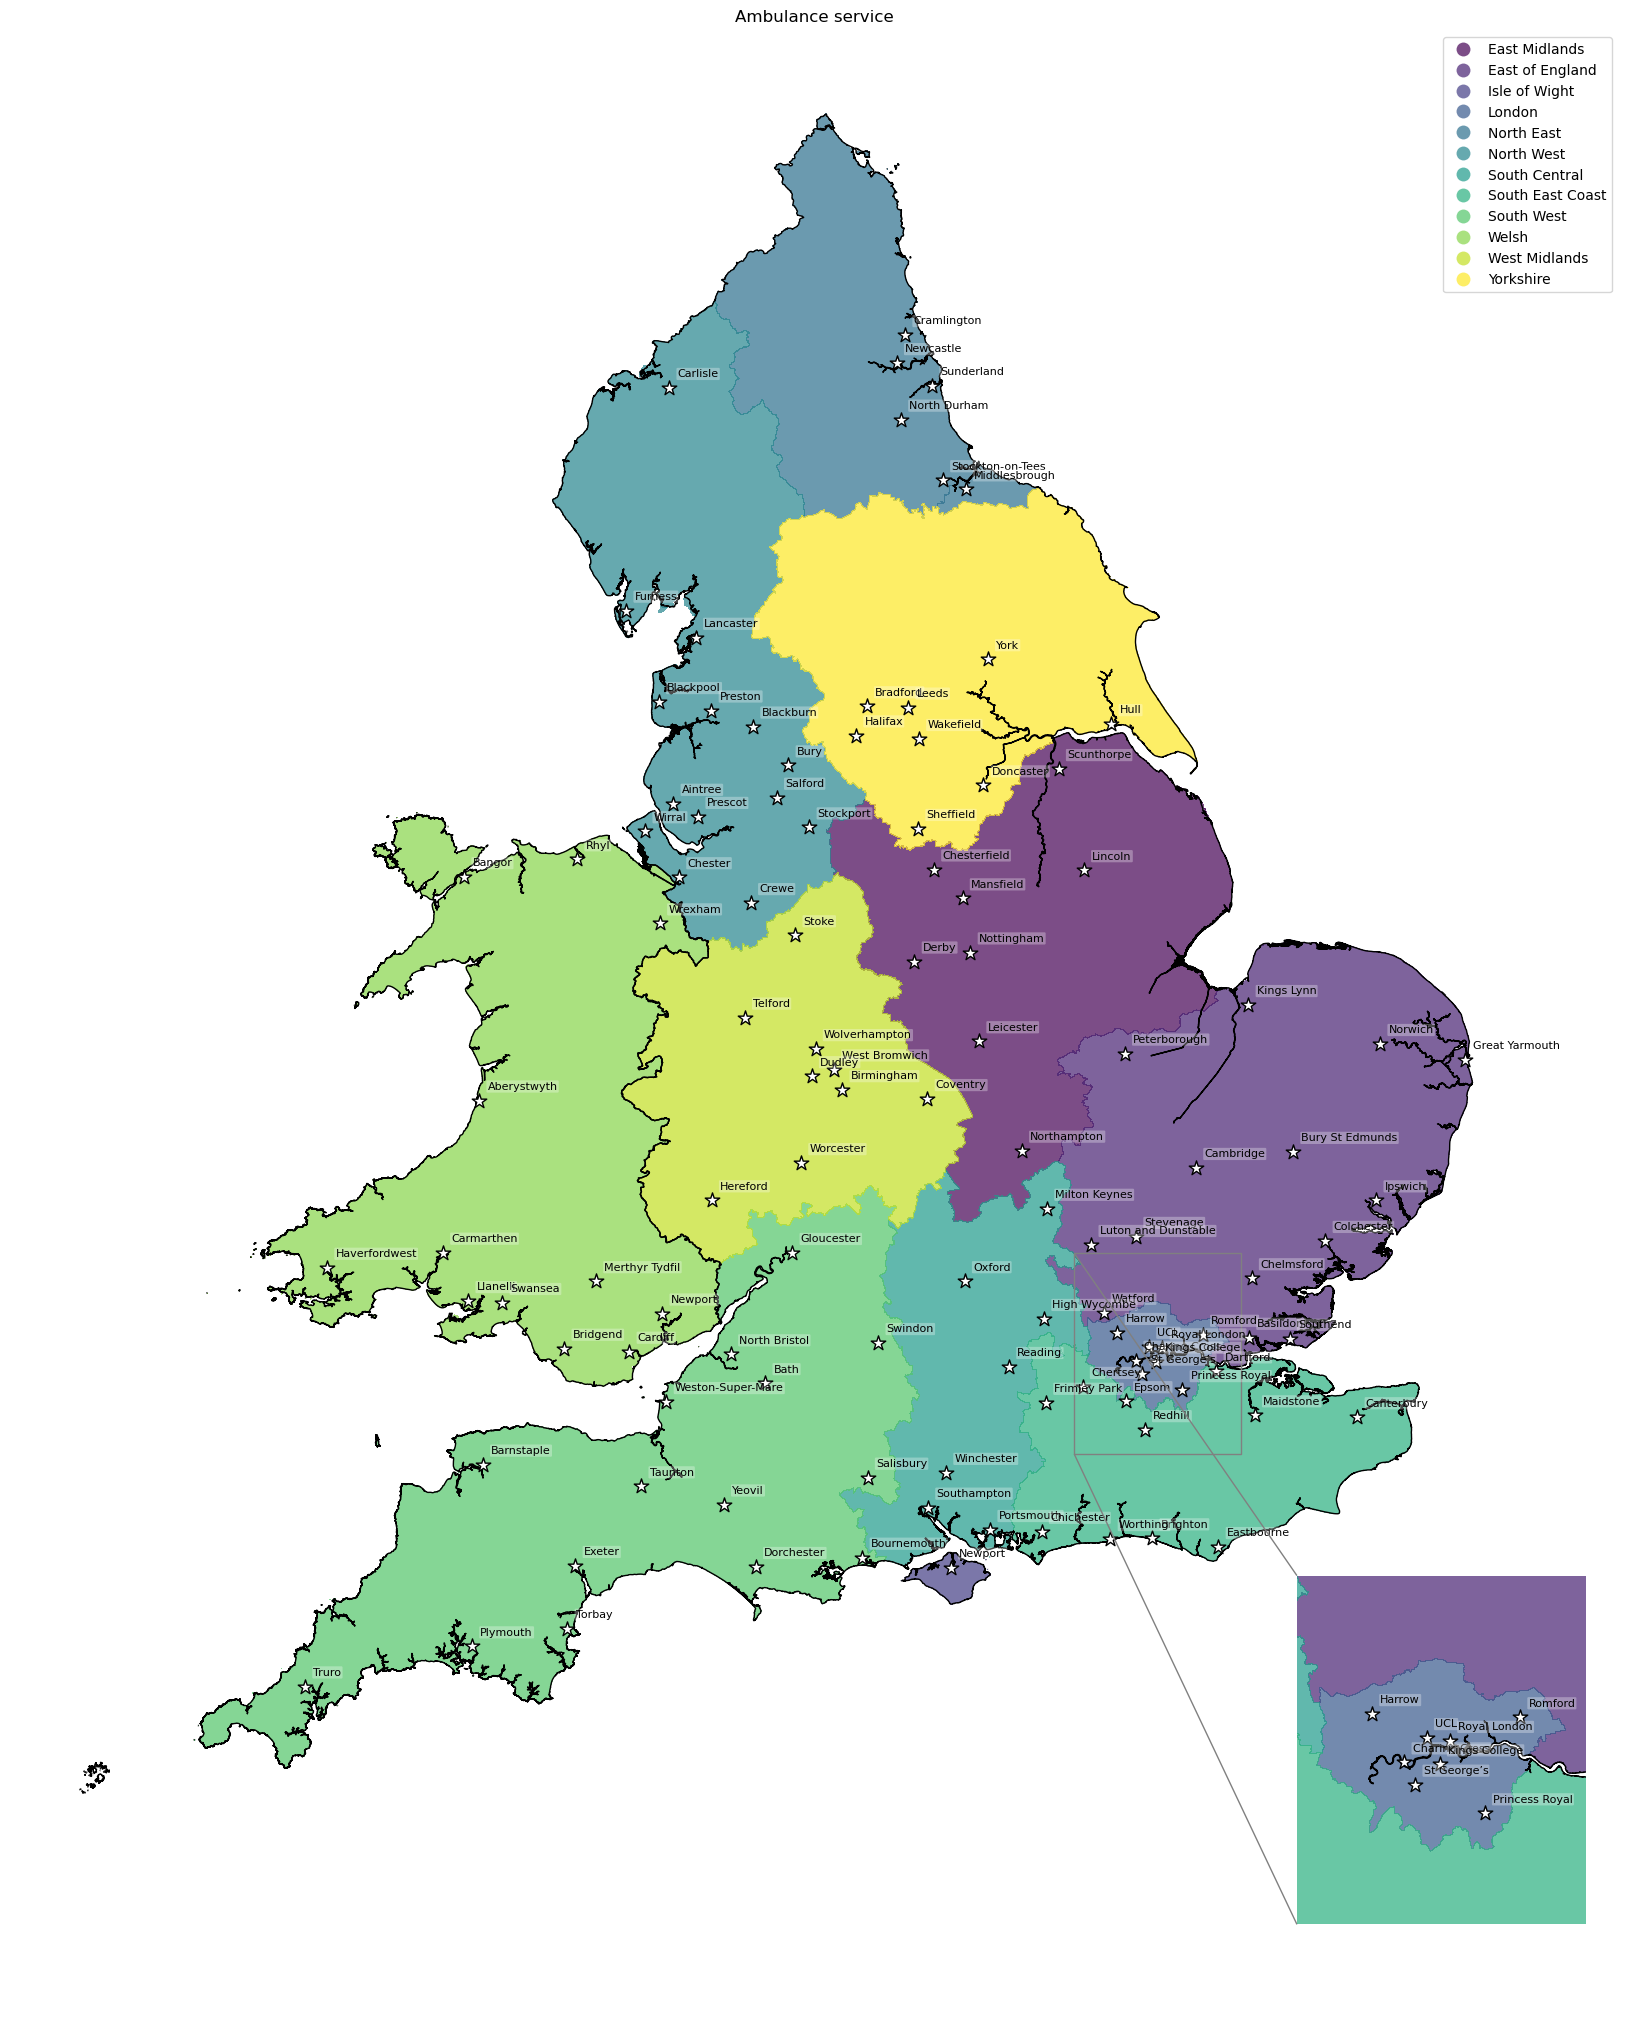

In [20]:
# Create map
create_map(
    gdf=gdf_amb_catchment,
    col='ambulance_service',
    col_readable='Ambulance service',
    gdf_units=gdf_units,
    base_map=False,
    show_labels=True,
    cmap='viridis')